In [32]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from glob import glob
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose,
    MaxPooling2D, concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image , ImageFilter
from tensorflow.keras.losses import BinaryCrossentropy

# **Load images path and masks path**

In [2]:
train_files = []
mask_files = glob(r'C:\Users\hp\Downloads\imageproject\lgg-mri-segmentation\kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['C:\\Users\\hp\\Downloads\\imageproject\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif', 'C:\\Users\\hp\\Downloads\\imageproject\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', 'C:\\Users\\hp\\Downloads\\imageproject\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', 'C:\\Users\\hp\\Downloads\\imageproject\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', 'C:\\Users\\hp\\Downloads\\imageproject\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif', 'C:\\Users\\hp\\Downloads\\imageproject\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_15.tif', 'C:\\Users\\hp\\Downloads\\imageproject\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_16.tif', 'C:\\Users\\hp\\Downloads\\imageproject\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_C

# **Data Visualization**

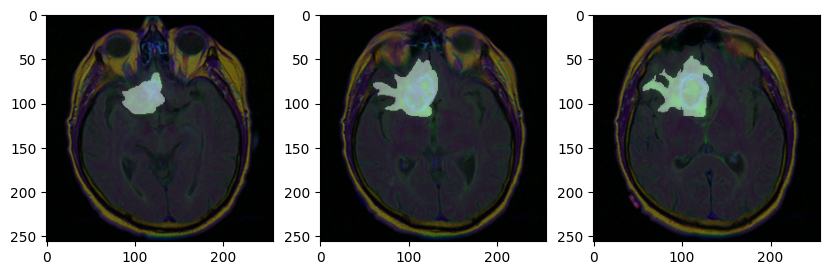

In [3]:
fig=plt.figure(figsize=(10,10))
for i in range(1,4):
    fig.add_subplot(3,3,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

# some Image processing

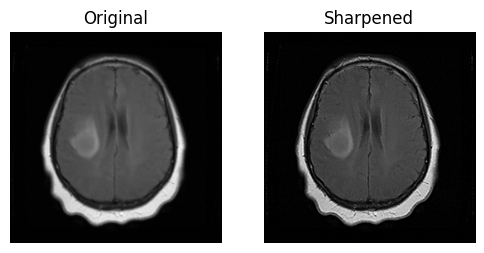

In [7]:
kernel = np.array([[0,-1,0],
                   [-1,5,-1],
                   [0,-1,0]])

sharp = cv2.filter2D(img, -1, kernel)

plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(sharp, cmap='gray')
plt.title("Sharpened")
plt.axis('off')

plt.show()

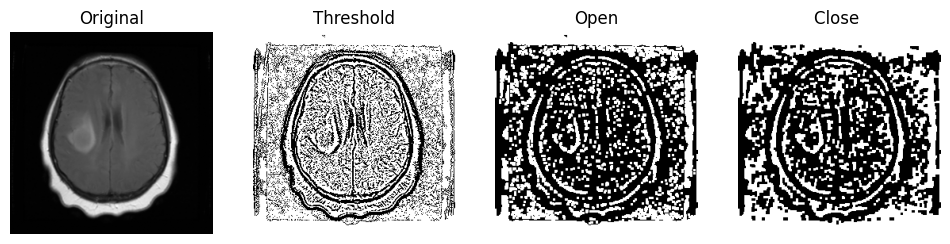

In [21]:
_, thresh = cv2.threshold(
    img, 0, 255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(
    th,
    cv2.MORPH_OPEN,
    kernel
)
closing = cv2.morphologyEx(
    opening,
    cv2.MORPH_CLOSE,
    kernel
)



plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(th, cmap='gray')
plt.title("Threshold")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(opening, cmap='gray')
plt.title("Open")
plt.axis("off")


plt.subplot(1,4,4)
plt.imshow(closing, cmap='gray')
plt.title("Close ")
plt.axis("off")

plt.show()


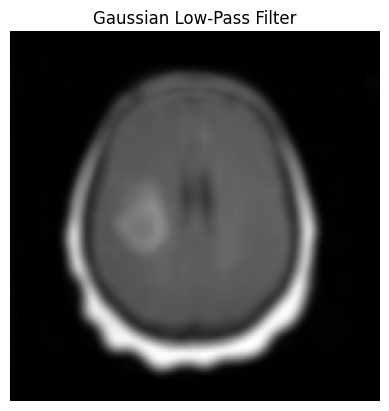

In [22]:
gaussian_lpf = cv2.GaussianBlur(img, (11, 11), 5)

plt.imshow(gaussian_lpf, cmap="gray")
plt.title("Gaussian Low-Pass Filter")
plt.axis("off")
plt.show()

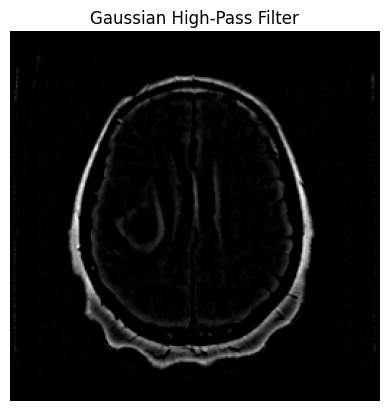

In [25]:
gaussian_lpf = cv2.GaussianBlur(img, (13, 13), 5)
gaussian_hpf = cv2.subtract(img, gaussian_lpf)

plt.imshow(gaussian_hpf, cmap="gray")
plt.title("Gaussian High-Pass Filter")
plt.axis("off")
plt.show()

# **split data on train set, validation set and test set**

In [36]:
df = pd.DataFrame(data={"brain": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


In [42]:
EPOCHS = 20
BATCH_SIZE = 64
learning_rate = 0.0001

In [38]:

def train_generator(data_frame, batch_size, aug_dict,seed=1 , target_size=(64,64) ,image_save_prefix="image", mask_save_prefix="mask"):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "brain",
        class_mode = None,
        color_mode = 'rgb',
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = None,
        save_prefix  = 'image',
        seed = seed)
    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = "grayscale",
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = None,
        save_prefix  = "mask",
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [39]:
from tensorflow.keras.layers import Conv2DTranspose, Input
from tensorflow.keras.models import Model

def cnn(input_shape=(64,64,3)):
    inputs = Input(input_shape)
    
    # Encoder
    x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    
    # Decoder
    x = Conv2DTranspose(32, 2, strides=2, padding='same', activation='relu')(x)
    x = Conv2DTranspose(32, 2, strides=2, padding='same', activation='relu')(x)
    
    outputs = Conv2D(1, 1, activation='sigmoid', padding='same')(x)  # Output mask same size
    return Model(inputs, outputs)

model = cnn(input_shape=(64,64,3))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │         8,224 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │         4,128 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 1)      │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,025 (160.25 KB)

 Trainable params: 41,025 (160.25 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=0.0001
    ),

    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    )
]

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE, train_generator_args, target_size=(64,64))
    
test_gener = train_generator(df_val, BATCH_SIZE,dict(),target_size=(64,64))
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) // BATCH_SIZE, 
                    epochs=20, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) // BATCH_SIZE)


Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9898 - loss: 0.2979Found 708 validated image filenames.
Found 708 validated image filenames.
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 509ms/step - accuracy: 0.9897 - loss: 0.1834 - val_accuracy: 0.9903 - val_loss: 0.0527 - learning_rate: 0.0010
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 445ms/step - accuracy: 0.9897 - loss: 0.0401 - val_accuracy: 0.9901 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - accuracy: 0.9896 - loss: 0.0524 - val_accuracy: 0.9906 - val_loss: 0.0379 - learning_rate: 0.0010
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9899 - loss: 0.0425
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 430ms/step - accuracy: 0.9900 - loss: 0.0379 - val_accuracy: 0.9898 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 5/5
44/44 ━

In [47]:
model = load_model('unet_brain_mri_seg.keras')

In [49]:
test_gen = train_generator(
    df_test,
    BATCH_SIZE,
    dict(),
    target_size=(128, 128)
)

results = model.evaluate(
    test_gen,
    steps=len(df_test) // BATCH_SIZE
)

print("Test Loss:", results[0])
print("Test Accuracy:", results[1])


Found 393 validated image filenames.
Found 393 validated image filenames.
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - binary_accuracy: 0.9887 - loss: 0.0586
Test Loss: 0.05856481194496155
Test Accuracy: 0.9887134432792664


# **Unet Model**

In [52]:
def unet(input_size=(128,128,3)):

    inputs = Input(input_size)

    # ------- Encoder -------
    c1 = Conv2D(64,3,padding='same', activation='relu')(inputs)
    c1 = Conv2D(64,3,padding='same', activation='relu')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128,3,padding='same', activation='relu')(p1)
    c2 = Conv2D(128,3,padding='same', activation='relu')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(256,3,padding='same', activation='relu')(p2)
    c3 = Conv2D(256,3,padding='same', activation='relu')(c3)

    # ------- Decoder -------
    u1 = Conv2DTranspose(64,2,strides=2,padding='same')(c3)
    u1 = concatenate([u1,c2])
    c4 = Conv2D(128,3,padding='same', activation='relu')(u1)
    c4 = Conv2D(128,3,padding='same', activation='relu')(c4)

    u2 = Conv2DTranspose(32,2,strides=2,padding='same')(c4)
    u2 = concatenate([u2,c1])
    c5 = Conv2D(64,3,padding='same', activation='relu')(u2)
    c5 = Conv2D(64,3,padding='same', activation='relu')(c5)

    outputs = Conv2D(1,1,activation='sigmoid')(c5)

    return Model(inputs, outputs)

In [53]:
model = unet()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_10[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_12[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 64, 64,    │     65,600 │ conv2d_13[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 192)              │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │    221,312 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_14[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 128, 128,  │     16,416 │ conv2d_15[0][0]   │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 96)               │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │     55,360 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_16[0][0] 

 Total params: 1,688,673 (6.44 MB)

 Trainable params: 1,688,673 (6.44 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
EPOCHS = 15
BATCH_SIZE = 64
learning_rate = 0.0001

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE, train_generator_args, target_size=(128,128))
    
test_gener = train_generator(df_val, BATCH_SIZE,dict(),target_size=(128,128))
    
model = unet(input_size=(128, 128, 3))



decay_rate = learning_rate / EPOCHS
opt = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=opt,
    loss=BinaryCrossentropy(),
    metrics=["binary_accuracy"]
)

callbacks = [
    ModelCheckpoint(
        'unet_brain_mri_seg.keras', 
        verbose=1,
        save_best_only=True
    )
]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) // BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) // BATCH_SIZE)



Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/15
 3/44 ━━━━━━━━━━━━━━━━━━━━ 13:26 20s/step - binary_accuracy: 0.8690 - loss: 0.6899

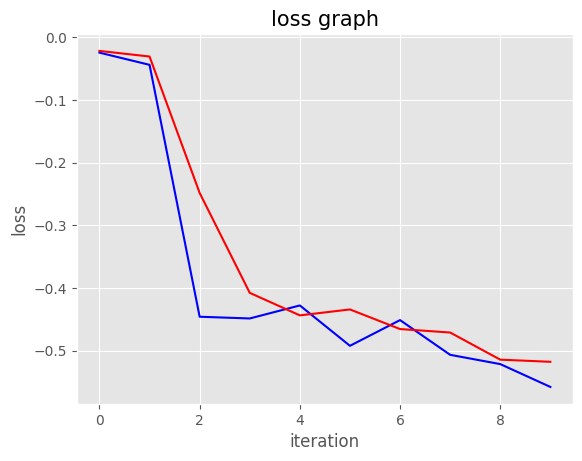

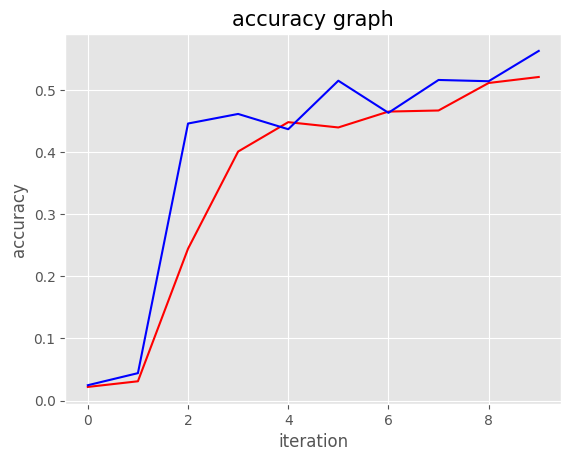

In [ ]:
a = history.history
a = history.history

list_trainacc = a['binary_accuracy']
list_valacc   = a['val_binary_accuracy']

list_trainloss = a['loss']
list_valloss   = a['val_loss']

plt.plot(list_trainloss, 'r', label='Train Loss')
plt.plot(list_valloss, 'b', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(list_trainacc, 'r-', label='Train Accuracy')
plt.plot(list_valacc, 'b-', label='Validation Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Binary Accuracy')
plt.title('Accuracy Graph', fontsize=15)
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(128, 128))
results = model.evaluate(test_gen, steps=len(df_test) // BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 918ms/step - binary_accuracy: 0.9913 - dice_coef: 0.5416 - iou: 0.3757 - loss: -0.5416
Test lost:  -0.5415746569633484
Test IOU:  0.991302490234375
Test Dice Coefficent:  0.3756948709487915


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


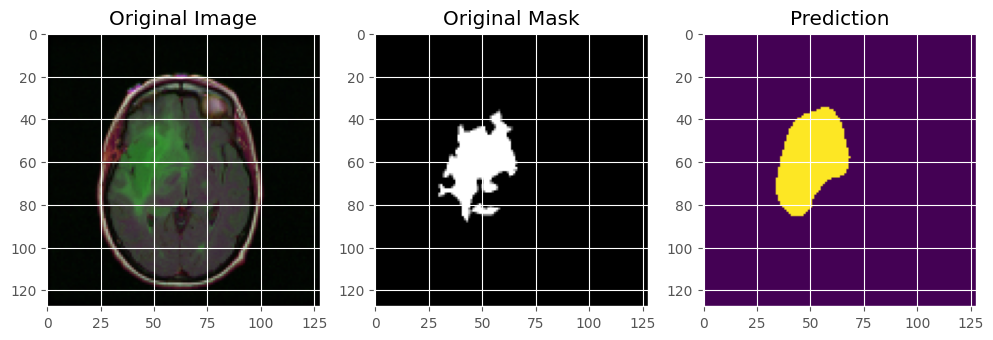

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


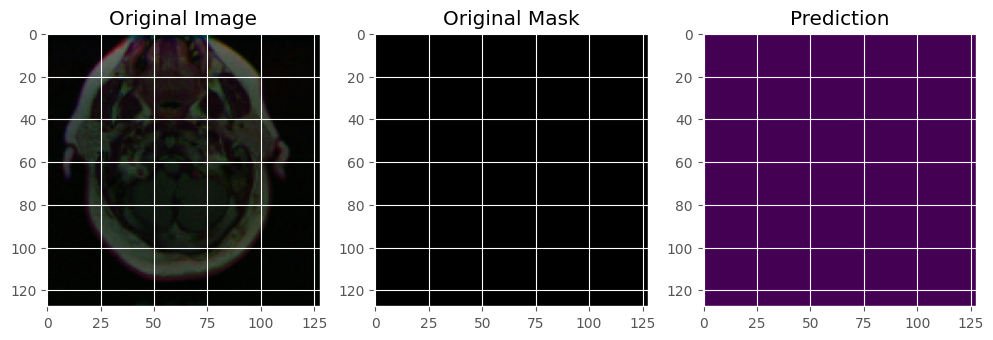

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


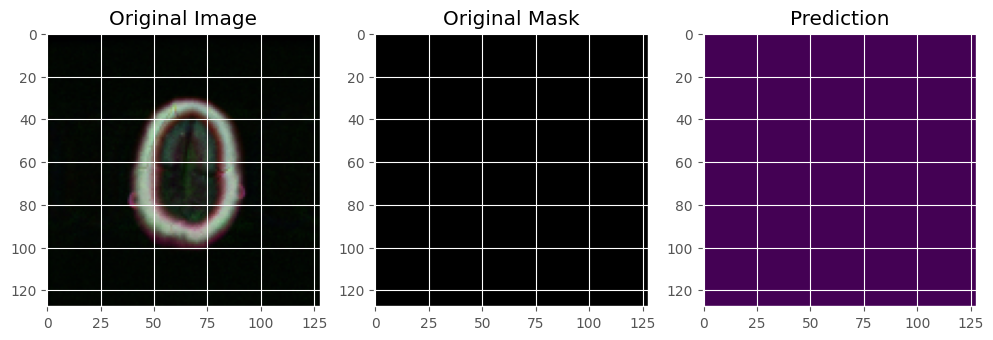

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


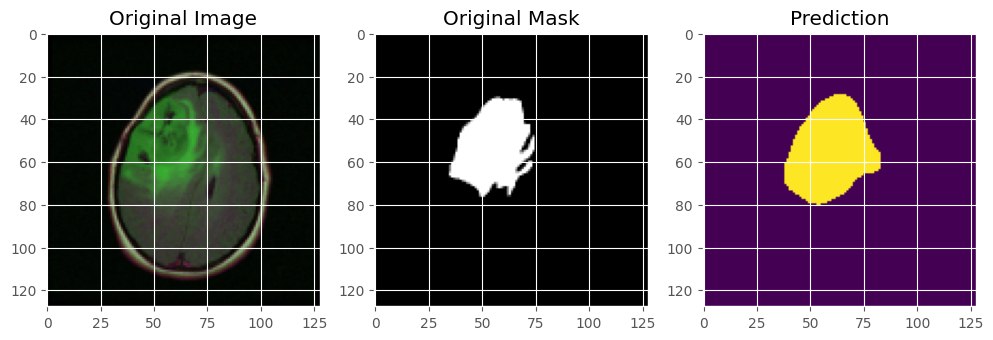

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


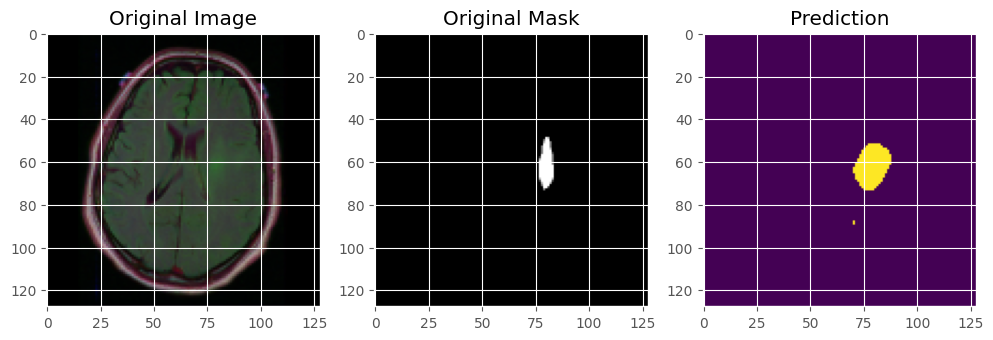

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


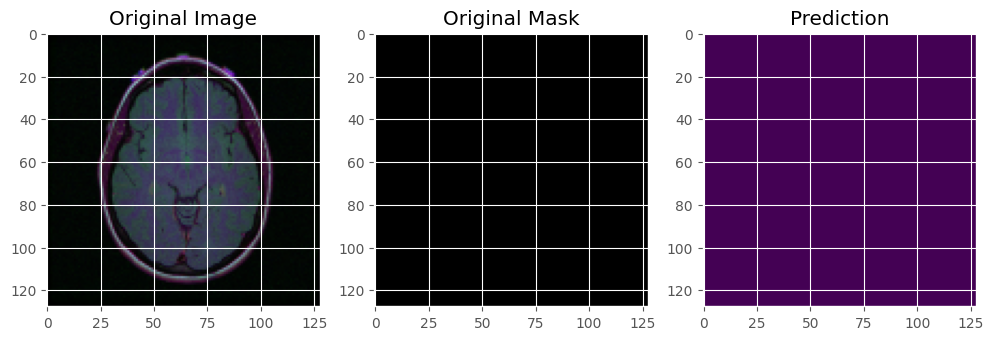

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


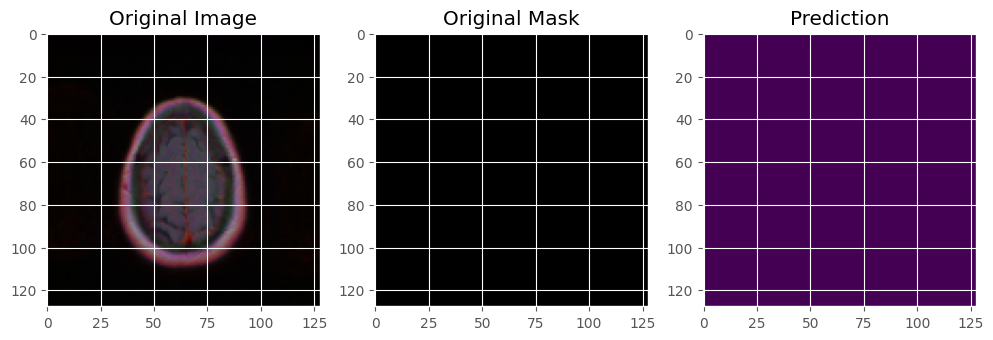

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


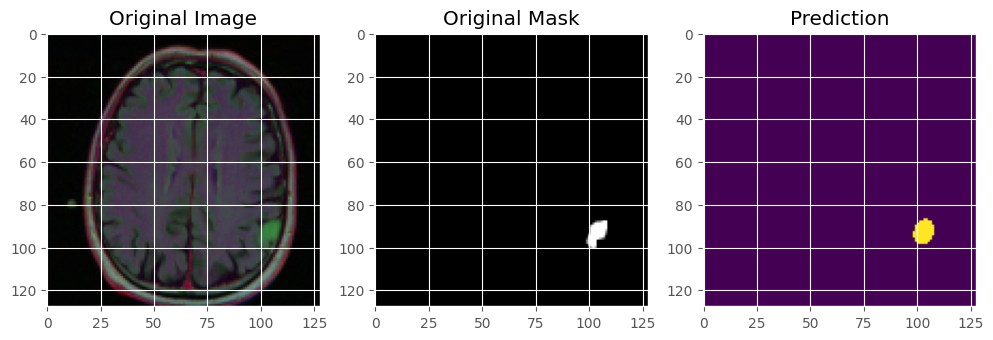

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


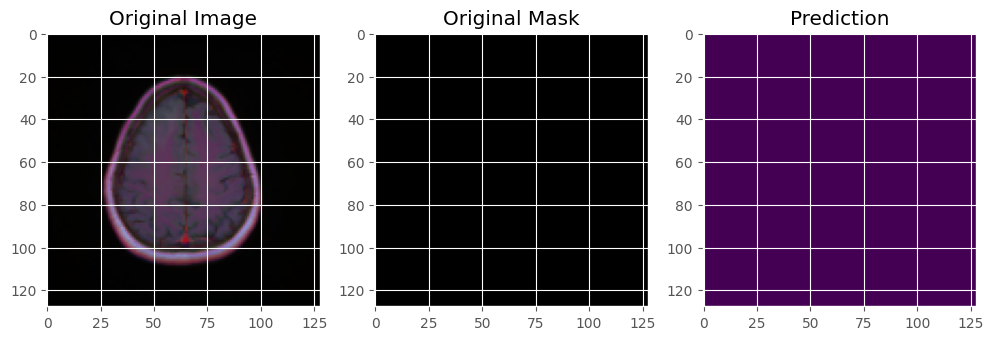

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


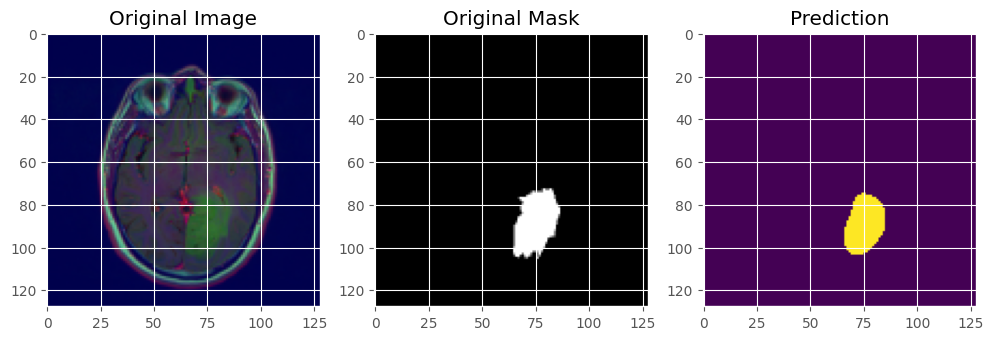

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


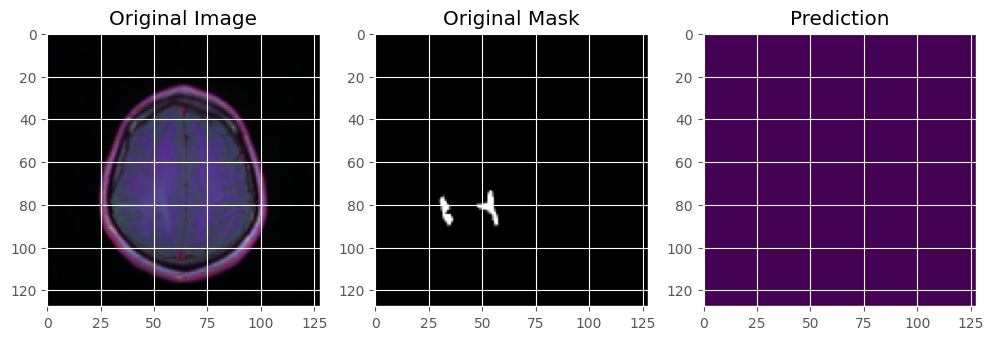

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


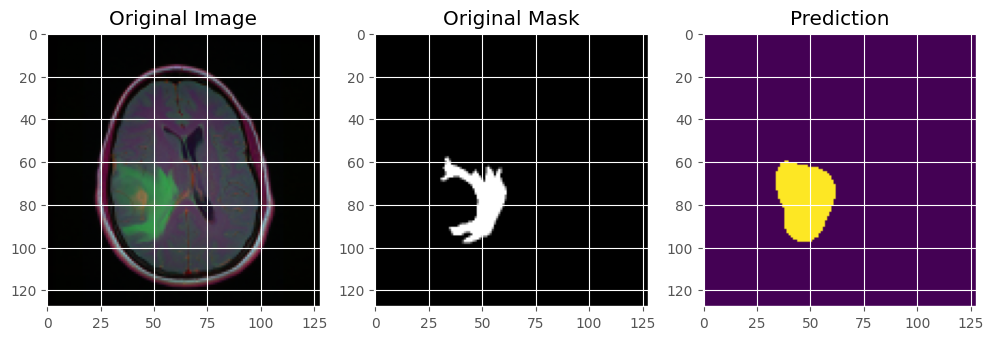

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


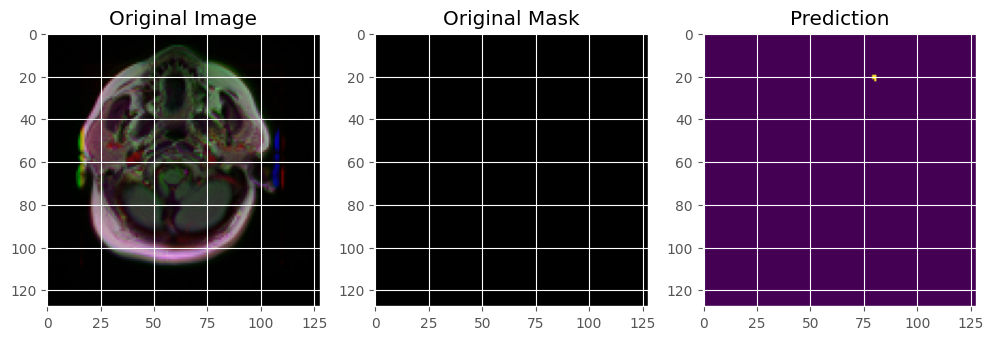

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


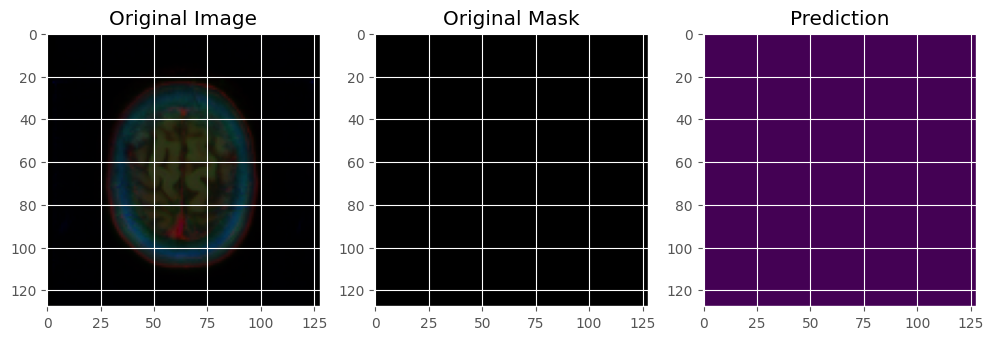

In [42]:

start = 26
num_images = 40

for i in range(start, num_images):

    img = cv2.imread(df_test['filename'].iloc[i])
    img = cv2.resize(img ,(im_height, im_width))
    img_norm = img / 255.0
    img_input = img_norm[np.newaxis, :, :, :]

    pred = model.predict(img_input)

    plt.figure(figsize=(12,12))

    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img_norm))
    plt.title('Original Image')

    plt.subplot(1,3,2)
    mask = cv2.imread(df_test['mask'].iloc[i])
    mask = cv2.resize(mask, (im_height, im_width))
    plt.imshow(mask)
    plt.title('Original Mask')

    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > 0.5)
    plt.title('Prediction')

    plt.show()
